In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI

In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np

In [4]:
t0, tf, steps = 0.0, 2.0, 1000
dt = (tf - t0) / steps
m = 1
g = 9.8

In [5]:
q = cs.SX.sym('q', 1)
v = cs.SX.sym('v', 1)
I = m

kinetic = cs.Function(
    'kinetic', [q, v], [0.5 * v.T @ I * v]
)
potential = cs.Function(
    'potential', [q], [-m * g * (1 - cs.cos(q))]
)
lagrangian = cs.Function(
    'lagrangian', [q, v], [kinetic(q, v) - potential(q)]
)

In [6]:
di = DI(
    nq=1,
    nu=0,
    lagrangian=lagrangian,
)

In [7]:
def simulate(q_0=0, v_0=0):
    qs_sol = np.zeros((steps, 1))
    qs_sol[0] = q_0
    qs_sol[1] = q_0 + v_0 * dt

    for i in range(2, steps):
        q0 = qs_sol[i - 2]
        q1 = qs_sol[i - 1]

        qs_sol[i] = di.step(q0, q1, dt)
    
    vs_sol = np.zeros((steps, 1))
    for i in range(1, steps):
        vs_sol[i] = (qs_sol[i] - qs_sol[i - 1]) / dt

    Ks = np.zeros((steps, 1))
    Ps = np.zeros((steps, 1))
    for i in range(steps):
        Ks[i] = kinetic(qs_sol[i], vs_sol[i])
        Ps[i] = potential(qs_sol[i])

    Ks[0] = v_0 ** 2 * m / 2
    return qs_sol, vs_sol, Ks, Ps

In [8]:
# Initial angles for simulation
initial_angles = np.linspace(0, 2*np.pi, 20)
initial_velocities = np.linspace(-5, 5, 20)

# Simulate pendulum for each initial angle
results = []
for angle in tqdm(initial_angles):
    for vel in initial_velocities:
        qs, vs, Ks, Ps = simulate(angle, vel)
        results.append((qs, vs, Ks, Ps))

100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


In [18]:
results = np.array(results)

In [19]:
results.shape

(400, 4, 1000, 1)

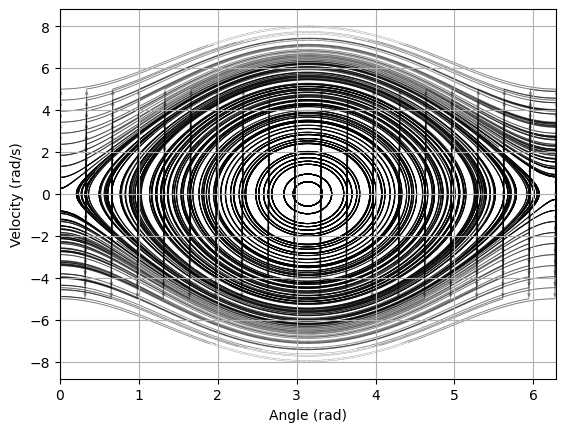

In [21]:
# Plot phase portrait with quivers
fig, ax = plt.subplots()
for qs, vs, _, _ in results:
    ax.quiver(qs[:-1], vs[:-1], qs[1:]-qs[:-1], vs[1:]-vs[:-1], scale_units='xy', angles='xy', scale=1, alpha=0.5)
ax.set_xlabel('Angle (rad)')
ax.set_ylabel('Velocity (rad/s)')
ax.set_xlim(0, 2*np.pi)
# ax.set_title('Phase Portrait (Variational Integrator)')
ax.grid()
plt.savefig('phase_portrait.png', dpi=300)

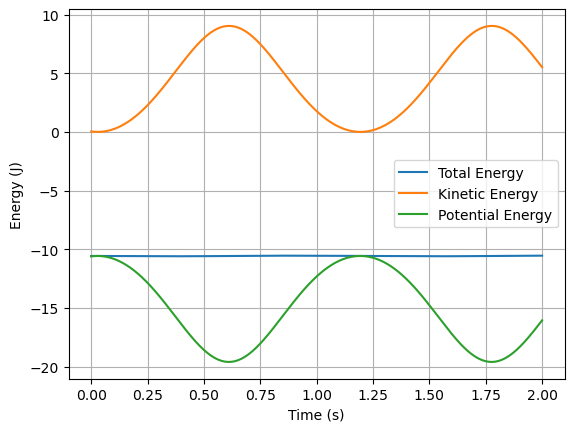

In [64]:
Ks, Ps = results[109][2], results[109][3]
fig, ax = plt.subplots()
ts = np.linspace(t0, tf, steps)

ax.plot(ts, Ks + Ps, label='Total Energy')
ax.plot(ts, Ks, label='Kinetic Energy')
ax.plot(ts, Ps, label='Potential Energy')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (J)')
# ax.set_title('Energy Conservation (Variational Integrator)')
ax.legend()
ax.grid()

plt.savefig('energies_109.png', dpi=300)

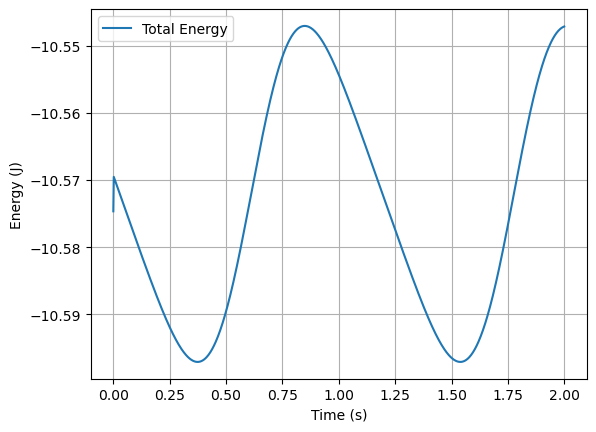

In [65]:
Ks, Ps = results[109][2], results[109][3]
fig, ax = plt.subplots()
ts = np.linspace(t0, tf, steps)

ax.plot(ts, Ks + Ps, label='Total Energy')
# ax.plot(ts, Ks, label='Kinetic Energy')
# ax.plot(ts, Ps, label='Potential Energy')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (J)')
# ax.set_title('Energy Conservation (Variational Integrator)')
ax.legend()
ax.grid()

plt.savefig('total_energy_109.png', dpi=300)